# 🤒 Epidemic mitigation project

## Google colab setup

In [1]:
# Mount drive and define root path 
import os
import sys

#from google.colab import drive
#drive.mount('/content/drive')

ROOT_PATH = "RL" 
print(os.listdir(ROOT_PATH))

sys.path.append(ROOT_PATH)

['.DS_Store', 'epidemic_env', 'readme.md', 'requirements_colab.txt', 'example.png', 'latex_template.tex', 'config', 'Miniproject_DQN.pdf', 'tutorial.ipynb', 'figures']


## Installing and importing the relevant packages

In [2]:
# Install necessary packages
requirements = ROOT_PATH + "/requirements_colab.txt"
%pip install -r {requirements}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 107.0 MB/s eta 0:00:00
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827633 sha256=98594cfd1ee9b26c74e9ce5e9919ed553294b3a9bca1c2cee228f0204d4fa281
  Stored in directory: /home/datalore/.cache/pip/wheels/17/79/65/7afedc162d858b02708a3b8f7a6dd5b1000dcd5b0f894f7cc1
Successfully built gym
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

from collections import namedtuple, deque
import random
import math
from itertools import count
import seaborn as sns
from typing import List
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Introduction

### Question 1.a) study the behavior of the model when epidemics are unmitigated

Run the epidemic simulation for one episode (30 weeks), without epidemic mitigation (meaning no action is
taken, i.e. all values in the action dictionary are set to False) and produce three plots:

1. A plot of variables $s^{[w]}_{total}$; $e^{[w]}_{total}$; $i^{[w]}_{total}$; $r^{[w]}_{total}$; $d^{[w]}_{total}$ over time, where time is measured in weeks and all the
variables share the y axis scaling.
2. A plot of variables $i^{[w]}_{total}$ and $d^{[w]}_{total}$ over time, where time is measured in weeks and all the variables share the
y axis scaling.
3. A set of plots of variables $i^{[w]}_{city}$ and $d^{[w]}_{city}$ over time, where time is measured in weeks (one subplot per-city,
variables share the y-scaling per-city).

**Discuss the evolution of the variables over time.**

In [4]:
#Load model of switzerland map
dyn = ModelDynamics(ROOT_PATH + '/config/switzerland.yaml') 
dyn.draw_map()

In [5]:
#Load environment 
env = Env(dyn) 

#Reset environement and set seed
obs, info = env.reset(seed=0)

#Define action that will be taken at each time step
action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

In [6]:
#Run simulation and save outputed dict
log = []
i, max_step = 0, 30
while i < max_step:
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    i+=1

#Parse log
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

In [7]:
#Plot episode using code provided in tutorial
from matplotlib.ticker import MultipleLocator
def plot_episode(total, cities, actions):
  fig = plt.figure(figsize=(14,10))
  ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
  ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
  ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
  ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
  ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
  ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

  [ax_leftstate.plot(y) for y in total.values()]
  ax_leftstate.legend(total.keys())
  ax_leftstate.set_title('Full state')
  ax_leftstate.set_ylabel('number of people in each state')

  [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
  ax_leftobs.legend(['infected','dead'])
  ax_leftobs.set_title('Observable state')
  ax_leftobs.set_ylabel('number of people in each state')

  ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
  ax_leftactions.set_title('Actions')
  ax_leftactions.set_yticks([0,1,2,3])
  ax_leftactions.set_yticklabels(list(actions.keys()))
  ax_leftactions.set_xlabel('time (in weeks)')

  [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
  [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
  [ax.set_ylabel(c) for c, ax in ax_right.items()]
  [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
  ax_right['Zürich'].set_xlabel('time (in weeks)')
  ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

  fig.tight_layout()
  plt.show()

In [8]:
plot_episode(total, cities, actions)

**TODO Disscuss evolution**
We see that when no action is taken the 

## 2. Professor Russo’s Policy

### Question 2.a) Implement Pr. Russo’s Policy
Implement Pr. Russo’s Policy as a python class (we recommend that you subclass the Agent abstract class
provided with the project files, and as is demonstrated in the tutorial notebook). Run the epidemic simulation
for one episode using Pr. Russo’s Policy to pick actions and produce four plots:
1. A plot of variables $s^{[w]}_{total}$; $e^{[w]}_{total}$; $i^{[w]}_{total}$; $r^{[w]}_{total}$; $d^{[w]}_{total}$ over time, where time is measured in weeks and all the variables share the y axis scaling.
2. A plot of variables $i^{[w]}_{total}$ and  $d^{[w]}_{total}$ over time, where time is measured in weeks and all the variables share the y axis scaling.
3. A set of plots of variables $i^{[w]}_{city}$ and $d^{[w]}_{city}$ over time, where time is measured in weeks (one subplot per-city, variables share the y-scaling per-city).
4. A plot of the action taken by the policy over time (whether the policy chooses to confine or not).

**Discuss how the epidemic simulation responds to Dr. Russo’s Policy (focus on how it differs from the
unmitigated scenario).**

In [9]:
#Define Dr. Russo's policy agent 
class RussoAgent(Agent):
    def __init__(self,  env:Env,
                ):
        """
        Confine country when total infected is > 20'000 for four week
        """
        self.env = env
        self.confine_at_infected = 20000 #set threshold to begin confinement
        self.length_confinement = 4 #set length of confinement 
        self.duration_current_confinement = 0 #Remember length of current confinement

    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,seed):
        # This should be called when the environment is reset
        self.env.reset(seed)

    def act(self, obs, info = None):
        # takes an observation and returns an action
        action = {'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False} #Do nothing

        if self.duration_current_confinement == self.length_confinement:
          self.duration_current_confinement = 0 #reset duration when confinement lasted 4 weeks

        if self.duration_current_confinement > 0:
          action = {'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False}
          self.duration_current_confinement += 1

        elif obs.total.infected[-1] > self.confine_at_infected:
          action = {'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False} #Confine
          self.duration_current_confinement = 1

        return action

In [10]:
#Load environment 
env = Env(dyn) 

#Reset environement and set seed
obs, info = env.reset(seed=0)

#Define Russo agent 
agent = RussoAgent(env)
agent.reset(0)

In [11]:
#Run simulation and save outputed dict
log = []
i, max_step = 0, 30
while i < max_step:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info)
    i+=1

#Parse log
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

In [12]:
plot_episode(total, cities, actions)

**TODO discuss evolution and compare with part 1.**

### Question 2.b) Evaluate Pr. Russo’s Policy
In order to be able to make meaningful conclusions about the behavior of the policy, you will need properly evaluate its behavior. To do so, running a single episode is not enough. Implement the following evaluation procedure: run 50 simulation episodes where actions are chosen from policy (in this case  will be Russo, but you should make the effort to write evaluation code in which you can easily change the policy being evaluated
as you will be asked to evaluate each policy you train later). For each episode, save the following values:
1. the number of total confined days $N_{confinement} = 7$ number of confined weeks ,
2. the cumulative reward (the sum of all rewards collected during the episode) $R_{cumulative} = \sum_{i\in[0,30]}{R^{[i]}}$.
3. the number of total deaths $N_{deaths} = d^{[30]}_{total}$
total,

Make sure to always be using the same sequence of random seeds (see the tutorial notebook for details on the environment seed) when evaluating different policies, in order to ensure that results are repoducible. (To
check that they are, run the eval twice, and check that you get the same average values). Once those values are logged for each episode, plot a histogram. (Use the histogram plotting function from the tutorial notebook.)

In [13]:
def evaluate_policy (policy, env, nb_episode:int, seed:List[int]):
  '''
  Run multiple episode using the inputed policy and compute for each episode:
  - the total number of confinement days/weeks
  - the cummulative reward
  - the total number of deaths
  parameters:
    policy: 
      policy used to chose next action
    env: 
      environment for the simulation
    nb_episode: int,
      number of episode played for the estimation
    seeds: int, 
      random sequence of seeds of length nb_episode for reproducibility
  '''

  #Run multiple episodes
  N_conf, cum_reward, nb_deaths = [], [], []
  for i in range(0,nb_episode):
    #Reset environement/agent and set seed
    obs, info = env.reset(seeds[i])
    policy.reset(seeds[i])
    
    finished = False
    ep_N_conf, ep_reward = 0, 0
    while not finished:
      action = policy.act(obs)
      obs, R, finished, info = env.step(action)

      #Log reward + confinement week
      ep_reward += R.item()
      ep_N_conf += int(action['confinement'] == True)

    N_conf.append(ep_N_conf); cum_reward.append(ep_reward)
    nb_deaths.append(obs.total.dead[-1])

  return N_conf, cum_reward, nb_deaths

In [14]:
seeds = np.arange(0,50,1)
N_conf, cum_reward, nb_deaths = evaluate_policy(agent, env, 50, seeds)

print(f'Average number of confinement weeks per episode: ', np.mean(N_conf))
print('Average cummulative reward: ', np.mean(cum_reward))
print('Average number of deaths: ', np.mean(nb_deaths))

Average number of confinement weeks per episode:  14.32
Average cummulative reward:  -69.96264824778075
Average number of deaths:  58071.94


In [15]:
#Define histogram plotting function from the tutorial
def hist_avg(ax, data, title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)

In [16]:
fig, ax = plt.subplots(2,2,figsize=(18,8))

hist_avg(ax[0,0], nb_deaths,'deaths')
hist_avg(ax[0,1], cum_reward,'cumulative rewards')
N_conf = [x*7 for x in N_conf] #Convert N_conf in days from week
hist_avg(ax[1,0], N_conf,'confined days')

fig.delaxes(ax[1,1])
fig.tight_layout()
plt.show()

## 3 A Deep Q-learning approach

### Question 3.a) implementing Deep Q-Learning

Implement and train the Deep Q-Learning agent DQN for 500 training episodes, with  = 0:7. For each episode, log the cumulative reward. You will see that Deep Q-Learning training curves are quite noisy, so to better evaluate the learning process we ask you to implement the following evaluation procedure.

Algorithm 2: Training/Logging procedure for DQN:
```python 
for episode in 500 do
    Run an episode.
    Log the cumulative reward Rcumulative to training trace.
    Run a training step.

    if episode % 50 = 0 or episode = 500 then
    Run a 20 episode evaluation procedure, log their cumulative rewards.
    Compute the average cumulative reward over the 20 evaluation episodes and log it to eval trace.
    end
end
```

The total training time is 500 episodes. Every 50 episodes, run a 20 episode evaluation process with  = 0 (no exploration) and no learning occurring and compute an average cumulative reward across the 20 episodes. We call the plot of the training reward, the training trace and the plot of the evaluation reward the evaluation trace. For the evaluation procedure before, be careful to always use the same seed, to ensure repoducible results. 

Once you have successfully done so, plot the training trace and the eval trace. (We expect a plot of the rewardin y and the training episode in x both for the training trace and the eval trace). It might be more readable to plot the training trace as a scatter plot. Since training results can be hard to reproduce, we ask you to average the eval trace across three full training processes (for the training trace, you can just scatter-polt the three trainings together). Do not forget to save your trained weights (the ones which gave the best reward on evaluation) for later evaluation. 

Does your agent learn a meaningful policy?

Record three example episodes where actions are picked by the best policy DQN you obtain. Plot one of those episodes, using the same plotting procedure as in question 2.a) and interpret the policy.

In [17]:
#Set seed for used libraries
random.seed(0)
torch.manual_seed(0)

In [18]:
#Define replay buffeer for decoralated batches
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [19]:
#Define network for DQN
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, n_actions)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

In [20]:

#Select binary action using epsilon greedy
def select_action_binary(policy_net, state, epsilon):
    sample = random.random()

    action = {'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}
    if sample > epsilon:
        with torch.no_grad():
            #We pick action with the larger expected reward.
            output = policy_net(state).argmax().view(1, 1)
    else:
      #Pick random action
      output = torch.tensor([[random.randint(0, 1)]], device=DEVICE, dtype=torch.long).view(1, 1)
      
    action['confinement'] = bool(output)

    return action, output

In [21]:
#Define training loop
def optimize_model(policy_model, target_model, memory, optimizer, criterion, BATCH_SIZE, GAMMA):
    if len(memory) < BATCH_SIZE:
      return 0
    #Get batch from memory buffer   
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=DEVICE, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) according to policy network
    state_action_values = policy_model(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states according to target_net.
    next_state_values = torch.zeros(BATCH_SIZE, device=DEVICE)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_model(non_final_next_states).max(1)[0]
    
    # Compute expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [22]:
def compute_epsilon(eps_min, eps_max, Tmax, t):
  epsilon = (eps_max*(Tmax-t))/Tmax
  return max(epsilon, eps_min)

def train_DQN(LR, EPS, BATCH_SIZE, GAMMA, eval_seeds, decreasing_eps=None):
  n_actions = 2
  state, info = env.reset()
  n_observations = 126

  if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    policy_net = nn.DataParallel(DQN(n_observations, n_actions).to(DEVICE))
    target_net = nn.DataParallel(DQN(n_observations, n_actions).to(DEVICE))
    target_net.load_state_dict(policy_net.state_dict())
  else:
    policy_net = DQN(n_observations, n_actions).to(DEVICE)
    target_net = DQN(n_observations, n_actions).to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())
      

  optimizer = optim.AdamW(policy_net.parameters(), lr=LR)
  criterion = nn.SmoothL1Loss()

  memory = ReplayMemory(20000)
  
  num_episodes = 500

  training_trace, eval_trace, losses_episode = [], [], []
  for i_episode in range(num_episodes):

      #Reset environment, get initial state
      state, info = env.reset()
      state = (torch.tensor([x.infected + x.dead for x in state.city.values()], dtype=torch.float32, device=DEVICE).flatten().view(1,-1))**(1/4)

      total_reward, loss_episode = 0, 0
      for t in count():
        
        #If decreasing eps compute epsilon
        if decreasing_eps:
          eps_min, eps_max, Tmax = decreasing_eps
          EPS = compute_epsilon(eps_min, eps_max, Tmax, t)

        #Get next action according to policy
        action, output = select_action_binary(policy_net, state, EPS)
            
        #Take action, observe reward + next state
        observation, reward, done, info = env.step(action)
        total_reward += reward
        reward = torch.tensor([reward], device=DEVICE)

        if done:
            next_state = None
        else:
            next_state = (torch.tensor([x.infected + x.dead for x in observation.city.values()], dtype=torch.float32, device=DEVICE).flatten().view(1,-1))**(1/4)

        # Store the transition in memory
        memory.push(state, output, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model(policy_net, target_net, memory, optimizer, criterion, BATCH_SIZE, GAMMA)
        loss_episode += loss

        #Fully update target network's weights every 5 episodes
        if (i_episode+1) % 5 == 0:
          target_net.load_state_dict(policy_net.state_dict())

        if done:
          training_trace.append(total_reward)
          losses_episode.append(loss_episode)
          break
      
      if (i_episode+1) % 50 == 0 or (i_episode+1) == 500:
        #Evaluate current model on 20 episodes
        eval_reward = []
        for i in range(20):
          #Reset environment, get initial state
          state, info = env.reset(eval_seeds[i])
          state = (torch.tensor([x.infected + x.dead for x in state.city.values()], dtype=torch.float32, device=DEVICE).flatten().view(1,-1))**(1/4)

          total_reward = 0
          for t in count():
            #Get next action according to policy
            with torch.no_grad():
              action, output = select_action_binary(target_net, state, 0)
                
            #Take action, observe reward + next state
            observation, reward, done, info = env.step(action)
            total_reward += reward.item()

            state = (torch.tensor([x.infected + x.dead for x in observation.city.values()], dtype=torch.float32, device=DEVICE).flatten().view(1,-1))**(1/4)

            if done:
              eval_reward.append(total_reward)
              break
          
        eval_trace.append(np.mean(eval_reward))
    
  return target_net, training_trace, eval_trace, losses_episode

In [23]:
#Hyperparameters
BATCH_SIZE = 2048
GAMMA = 0.9
EPS = 0.7
LR = 5e-3

#Load environment, train 3 times
env = Env(dyn) 
eval_seeds = np.arange(0,25*3)



best_reward = -10000
training_traces, eval_traces, losses = [],[],[]
for j in range(3):
  target_net, training_trace, eval_trace, loss_episode = train_DQN(LR, EPS, BATCH_SIZE, GAMMA, eval_seeds[25*j: 25*(j+1)])
  training_traces.append(training_trace); eval_traces.append(eval_trace); losses.append(loss_episode)

  if eval_trace[-1] > best_reward:
    best_reward = eval_trace[-1]

    torch.save(target_net.state_dict(), ROOT_PATH + "/best_DQN_3_1")

In [24]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] # Add more if you have more than 7 traces

for i, x in enumerate(training_traces):
    values = [e.item() for e in x]
    plt.scatter(np.arange(0, len(values)), values, color=colors[i % len(colors)])



plt.title('Training trace for three training procedures')
plt.show()

test = np.mean(eval_traces, axis=0)
plt.plot(np.arange(0,len(test)), test)
plt.title('Cummulative reward during evaluation')
plt.show()

In [25]:
losses = [x.detach().item() for x in losses[0] if x != 0]
plt.plot(losses)
plt.title('Episode loss during training')
plt.show()

In [28]:
from collections import OrderedDict
#Define DQN agent 
class first_binary_DQNagent(Agent):
    def __init__(self,  env:Env,
                ):
        """
        DQN agent with binary action space (confinment or not)
        """
        self.env = env
        if torch.cuda.device_count() > 1:
            self.model = nn.DataParallel(DQN(126, 2).to(DEVICE))
        else:
            self.model = DQN(126, 2).to(DEVICE)

    def load_model_no_parallel(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        self.model.load_state_dict(torch.load(savepath, map_location=torch.device(DEVICE)))

    def load_model(self, savepath):
    # Load the state dict from the file
        state_dict = torch.load(savepath,map_location=torch.device(DEVICE))

    # Create a new state dict in which the keys don't have the 'module.' prefix
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v

        # Load the weights
        self.model.load_state_dict(new_state_dict)

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        torch.save(self.model.state_dict(), ROOT_PATH + "/DQN_3_1")

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,seed):
        # This should be called when the environment is reset
        self.env.reset(seed)

    def act(self, obs):
        # takes an observation and returns an action
        with torch.no_grad():
          #We pick action with the larger expected reward.
          state = (torch.tensor([x.infected + x.dead for x in obs.city.values()], dtype=torch.float32, device=DEVICE).flatten().view(1,-1))**(1/4)
          action = {'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}
          action['confinement'] = bool(self.model(state).argmax().view(1, 1))

        return action

In [27]:
simulations = {}
for k in range(3):
    env = Env(dyn) 

    #Reset environement and set seed
    obs, info = env.reset(seed=k)

    #Define Russo agent 
    agent = first_binary_DQNagent(env)
    agent.load_model_no_parallel(ROOT_PATH +  '/best_DQN_3_1')
    agent.reset(0)


    log=[]
    Total = None
    Cities = None
    Actions = None

    i, max_step = 0, 30
    while i < max_step:
        action = agent.act(obs)
        obs, R, finished, info = env.step(action)
        log.append(info)
        i+=1

    #Parse log
    Total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    Cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    Actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    simulations[k] = {"total": Total, "cities" : Cities, "actions" : Actions }


In [29]:
plot_episode(simulations[0]["total"], simulations[0]["cities"], simulations[0]["actions"])

In [30]:
#Load environment 
env = Env(dyn) 

#Reset environement and set seed
obs, info = env.reset(seed=0)

#Define Russo agent 
agent = first_binary_DQNagent(env)
agent.load_model_no_parallel(ROOT_PATH +  '/best_DQN_3_1')
agent.reset(0)

seeds = np.arange(0,50,1)
N_conf, cum_reward, nb_deaths = evaluate_policy(agent, env, 50, seeds)

print(f'Average number of confinement weeks per episode: ', np.mean(N_conf))
print('Average cummulative reward: ', np.mean(cum_reward))
print('Average number of deaths: ', np.mean(nb_deaths))

Average number of confinement weeks per episode:  24.08
Average cummulative reward:  35.279600121825936
Average number of deaths:  1912.74


In [31]:
fig, ax = plt.subplots(2,2,figsize=(18,8))

hist_avg(ax[0,0], nb_deaths,'deaths')

hist_avg(ax[0,1], cum_reward,'cumulative rewards')

N_conf = [x*7 for x in N_conf] #Convert N_conf in days from week
hist_avg(ax[1,0], N_conf,'confined days')

fig.delaxes(ax[1,1])
fig.tight_layout()
plt.show()

### Question 3.b) decreasing exploration
Implement and train Deep Q-Learning agent for 500 training episodes with decreasing $\epsilon$:
$$ \epsilon(t) = max(\frac{ϵ_0(T_{max} - t)}{T_{max}}, ϵ_{min}) $$

where t is the episode number, Tmax = 500, 0 = 0:7 and min = 0:2.

Plot the evaluation and training traces on a shared plot with the traces from question 3.b), (we ask you to average across 3 training runs). 

Compare and discuss the results between questions 3.a) and 3.b). Which policy gets the best results and why?

In [32]:
def compute_epsilon(eps_min, eps_max, Tmax, t):
  epsilon = (eps_max*(Tmax-t))/Tmax
  return max(epsilon, eps_min)

In [33]:
#Hyperparameters
BATCH_SIZE = 2048
GAMMA = 0.9
EPS_min, EPS_max = 0.2, 0.7
LR = 5e-3
Tmax = 500

#Load environment, train 3 times
env = Env(dyn) 
eval_seeds = np.arange(0,25*3)


best_reward = -10000
training_traces, eval_traces, losses = [],[],[]
for j in range(3):
  target_net, training_trace, eval_trace, loss_episode = train_DQN(LR, 0, BATCH_SIZE, GAMMA, eval_seeds[25*j: 25*(j+1)], [EPS_min, EPS_max, Tmax])
  training_traces.append(training_trace); eval_traces.append(eval_trace); losses.append(loss_episode)

  if eval_trace[-1] > best_reward:
    best_reward = eval_trace[-1]

    torch.save(target_net.state_dict(), ROOT_PATH + "/best_DQN_3_2")

In [34]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] 

for i, x in enumerate(training_traces):
    values = [e.item() for e in x]
    plt.scatter(np.arange(0, len(values)), values, color=colors[i % len(colors)])
    
plt.title('Training trace for three training procedures')
plt.show()



test = np.mean(eval_traces, axis=0)
plt.plot(np.arange(0,len(test)), test)
plt.title('Cummulative reward during evaluation')
plt.show()

In [35]:
losses = [x.detach().item() for x in losses[0] if x != 0]
plt.plot(losses)
plt.title('Episode loss during training')
plt.show()

### Question 3.c) evaluate the best performing policy against Pr. Russo’s policy
Run the best performing policy 
DQN through the evaluation code that you wrote to evaluate Pr. Russo’s policy
in question 2.b), generate the same histogram plots and compare the results. Did the reinforcement
learning policy outperform Pr. Russo’s, if so in what sense?

In [37]:
#Define DQN agent 
class binary_DQNagent(Agent):
    def __init__(self,  env:Env,
                ):
        """
        DQN agent with binary action space (confinment or not)
        """
        self.env = env
        self.model = DQN(126, 2).to(DEVICE)

    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        self.model.load_state_dict(torch.load(savepath))

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        torch.save(self.model.state_dict(), ROOT_PATH + "/DQN_3_2")

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,seed):
        # This should be called when the environment is reset
        self.env.reset(seed)

    def act(self, obs, info_ =None):
        # takes an observation and returns an action
        with torch.no_grad():
          #We pick action with the larger expected reward.
          state = (torch.tensor([x.infected + x.dead for x in obs.city.values()], dtype=torch.float32, device=DEVICE).flatten().view(1,-1))**(1/4)
          action = {'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}
          action['confinement'] = bool(self.model(state).argmax().view(1, 1))

        return action

In [38]:
simulations = {}
for k in range(3):
    env = Env(dyn) 

    #Reset environement and set seed
    obs, info = env.reset(seed=k)

    #Define Russo agent 
    agent = binary_DQNagent(env)
    agent.load_model(ROOT_PATH +  '/best_DQN_3_2')
    agent.reset(0)


    log=[]
    Total = None
    Cities = None
    Actions = None

    i, max_step = 0, 30
    while i < max_step:
        action = agent.act(obs)
        obs, R, finished, info = env.step(action)
        log.append(info)
        i+=1

    #Parse log
    Total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    Cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    Actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    simulations[k] = {"total": Total, "cities" : Cities, "actions" : Actions }

In [39]:
plot_episode(simulations[0]["total"], simulations[0]["cities"], simulations[0]["actions"])

In [40]:
#Load environment 
env = Env(dyn) 

#Reset environement and set seed
obs, info = env.reset(seed=0)

#Define Russo agent 
agent = binary_DQNagent(env)
agent.load_model(ROOT_PATH +  '/best_DQN_3_2')
agent.reset(0)

seeds = np.arange(0,50,1)
N_conf, cum_reward, nb_deaths = evaluate_policy(agent, env, 50, seeds)

print(f'Average number of confinement weeks per episode: ', np.mean(N_conf))
print('Average cummulative reward: ', np.mean(cum_reward))
print('Average number of deaths: ', np.mean(nb_deaths))

Average number of confinement weeks per episode:  22.24
Average cummulative reward:  33.790046245753764
Average number of deaths:  3838.68


In [41]:
fig, ax = plt.subplots(2,2,figsize=(18,8))

hist_avg(ax[0,0], nb_deaths,'deaths')

hist_avg(ax[0,1], cum_reward,'cumulative rewards')

N_conf = [x*7 for x in N_conf] #Convert N_conf in days from week
hist_avg(ax[1,0], N_conf,'confined days')

fig.delaxes(ax[1,1])
fig.tight_layout()
plt.show()

**TODO: COMPARE WITH DR:RUSSO POLICY. Outperforms??**

Better reward -> more confinement, a lot less deaths

## 4. Dealing with a more complex action Space
## 4.1 Toggle-action-space multi-action agent

In [42]:
# Include last action state in state representation
def get_state(observation, last_action_state):
    state = (torch.tensor([x.infected + x.dead for x in observation.city.values()], dtype=torch.float32, device=DEVICE).flatten().view(1,-1))**(1/4)
    last_action_state_tensor = torch.tensor(list(last_action_state.values()), dtype=torch.float32, device=DEVICE).view(1,-1)
    return torch.cat((state, last_action_state_tensor), dim=1)

#Select toggle multi-action using epsilon greedy
def select_toogle_action(policy_net, state, last_action, epsilon):
    action = last_action.copy()
    sample = random.random()

    if sample > epsilon:
        with torch.no_grad():
            #We pick action with the larger expected reward.
            output = policy_net(state).argmax().view(1, 1)
    else:
        #Pick random action
        output = torch.tensor([[random.randint(0, 4)]], device=DEVICE, dtype=torch.long)

    #Toggle action
    if int(output) != 0:
        key_toggle = list(action.keys())[(int(output)-1)]
        action[key_toggle] = not action[key_toggle]

    return action, output

In [43]:
def train_DQN(LR, decreasing_eps, BATCH_SIZE, GAMMA, eval_seeds):
    n_actions = 5
    state, info = env.reset()
    n_observations = 126 + len(info.action)  # add the length of action state to the observation space

    policy_net = DQN(n_observations, n_actions).to(DEVICE)
    target_net = DQN(n_observations, n_actions).to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.AdamW(policy_net.parameters(), lr=LR)
    criterion = nn.SmoothL1Loss()

    memory = ReplayMemory(20000)

    num_episodes = 500

    training_trace, eval_trace, losses_episode = [], [], []
    for i_episode in range(num_episodes):

        # Reset environment, get initial state
        state, info = env.reset()
        state = get_state(state, info.action)  # initial state

        total_reward, loss_episode = 0, 0
        for t in count():

            # Compute epsilon
            eps_min, eps_max, Tmax = decreasing_eps
            EPS = compute_epsilon(eps_min, eps_max, Tmax, t)

            # Get next action according to policy
            action, output = select_toogle_action(policy_net, state, info.action, EPS)

            # Take action, observe reward + next state
            observation, reward, done, info = env.step(action)
            total_reward += reward
            reward = torch.tensor([reward], device=DEVICE)

            if done:
                next_state = None
            else:
                next_state = get_state(observation, action)  # get state after action

            # Store the transition in memory
            memory.push(state, output, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            loss = optimize_model(policy_net, target_net, memory, optimizer, criterion, BATCH_SIZE, GAMMA)
            loss_episode += loss

            # Fully update target network's weights every 5 episodes
            if (i_episode+1) % 5 == 0:
                target_net.load_state_dict(policy_net.state_dict())

            if done:
                training_trace.append(total_reward)
                losses_episode.append(loss_episode)
                break

        if (i_episode+1) % 50 == 0 or (i_episode+1) == 500:
            # Evaluate current model on 20 episodes
            eval_reward = []
            for i in range(20):
                # Reset environment, get initial state
                state, info = env.reset(eval_seeds[i])
                state = get_state(state, info.action)  # include action states in observation

                total_reward = 0
                for t in count():
                    # Get next action according to policy
                    with torch.no_grad():
                        action, output = select_toogle_action(policy_net, state, info.action, 0)

                    # Take action, observe reward + next state
                    observation, reward, done, info = env.step(action)
                    total_reward += reward.item()

                    state = get_state(observation, action)  # include action states in observation

                    if done:
                        eval_reward.append(total_reward)
                        break

            eval_trace.append(np.mean(eval_reward))

    return target_net, training_trace, eval_trace, losses_episode

In [44]:
#Hyperparameters
BATCH_SIZE = 2048
GAMMA = 0.9
EPS_min, EPS_max = 0.2, 0.7
LR = 5e-5
Tmax = 500


#Load environment, train 3 times
env = Env(dyn) 
env.reset(0)
eval_seeds = np.arange(0,25*3)


best_reward = -10000
training_traces, eval_traces, losses = [],[],[]
for j in range(3):
  target_net, training_trace, eval_trace, loss_episode = train_DQN(LR, [EPS_min, EPS_max, Tmax], BATCH_SIZE, GAMMA, eval_seeds[25*j: 25*(j+1)])
  training_traces.append(training_trace); eval_traces.append(eval_trace); losses.append(loss_episode)

  if eval_trace[-1] > best_reward:
    best_reward = eval_trace[-1]

    torch.save(target_net.state_dict(), ROOT_PATH + "/best_DQN_4_1")

In [45]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] 

for i, x in enumerate(training_traces):
    values = [e.item() for e in x]
    plt.scatter(np.arange(0, len(values)), values, color=colors[i % len(colors)])
    
plt.title('Training trace for three training procedures')
plt.show()

test = np.mean(eval_traces, axis=0)
plt.plot(np.arange(0,len(test)), test)
plt.title('Cummulative reward during evaluation')
plt.show()

In [46]:
losses = [x.detach().item() for x in losses[0] if x != 0]
plt.plot(losses)
plt.title('Episode loss during training')
plt.show()

In [52]:
#Define DQN agent 
class toogle_DQNagent(Agent):
    def __init__(self,  env:Env,
                ):
        """
        DQN agent with toogle action space 
        """
        self.env = env
        self.model = DQN(130, 5).to(DEVICE)

    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        self.model.load_state_dict(torch.load(savepath))

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        torch.save(self.model.state_dict(), savepath)

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,seed):
        # This should be called when the environment is reset
        self.env.reset(seed)

    def act(self, state, info_):
        with torch.no_grad():
            # Get the state tensor
            state_tensor = get_state(state, info_.action)

            # Get the action from the policy net
            output = self.model(state_tensor).argmax().view(1, 1)

            action = info_.action.copy()

            # Toggle action
            if int(output) != 0:
                key_toggle = list(action.keys())[(int(output)-1)]
                action[key_toggle] = not action[key_toggle]

        return action

In [53]:
#Load environment 
env = Env(dyn) 

#Reset environement and set seed
obs, info = env.reset(seed=0)

#Define Russo agent 
agent = toogle_DQNagent(env)
agent.load_model(ROOT_PATH +  '/best_DQN_4_1')
agent.reset(0)

#Run simulation and save outputed dict
log = []
i, max_step = 0, 30
while i < max_step:
    action = agent.act(obs, info)
    obs, R, finished, info = env.step(action)
    log.append(info)
    i+=1

#Parse log
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

In [57]:
log

[Log(total=Parameters(day=7, suceptible=3716090, exposed=21379, infected=1318, recovered=10947, dead=91, initial_population=3749837), city={'Lausanne': Parameters(day=7, suceptible=294999, exposed=0, infected=0, recovered=0, dead=0, initial_population=295000), 'Geneva': Parameters(day=7, suceptible=899999, exposed=0, infected=0, recovered=0, dead=0, initial_population=900000), 'Sion': Parameters(day=7, suceptible=34977, exposed=0, infected=0, recovered=0, dead=0, initial_population=34978), 'Neuchâtel': Parameters(day=7, suceptible=44530, exposed=0, infected=0, recovered=0, dead=0, initial_population=44531), 'Basel': Parameters(day=7, suceptible=828587, exposed=1169, infected=49, recovered=194, dead=0, initial_population=830000), 'Bern': Parameters(day=7, suceptible=133114, exposed=0, infected=0, recovered=0, dead=0, initial_population=133115), 'Lücern': Parameters(day=7, suceptible=81986, exposed=10, infected=0, recovered=2, dead=0, initial_population=82000), 'St-Gallen': Parameters(da

In [54]:
plot_episode(total, cities, actions)

In [60]:
def evaluate_policy (policy, env, nb_episode:int, seed:List[int]):
  '''
  Run multiple episode using the inputed policy and compute for each episode:
  - the total number of confinement days/weeks
  - the cummulative reward
  - the total number of deaths
  parameters:
    policy: 
      policy used to chose next action
    env: 
      environment for the simulation
    nb_episode: int,
      number of episode played for the estimation
    seeds: int, 
      random sequence of seeds of length nb_episode for reproducibility
  '''

  #Run multiple episodes
  N_conf, cum_reward, nb_deaths = [], [], []
  for i in range(0,nb_episode):
    #Reset environement/agent and set seed
    obs, info = env.reset(seeds[i])
    policy.reset(seeds[i])
    
    finished = False
    ep_N_conf, ep_reward = 0, 0
    while not finished:
      action = policy.act(obs, info)
      obs, R, finished, info = env.step(action)

      #Log reward + confinement week
      ep_reward += R.item()
      ep_N_conf += int(action['confinement'] == True)

    N_conf.append(ep_N_conf); cum_reward.append(ep_reward)
    nb_deaths.append(obs.total.dead[-1])

  return N_conf, cum_reward, nb_deaths

In [61]:
#Load environment 
env = Env(dyn) 

#Reset environement and set seed
obs, info = env.reset(seed=0)

#Define Russo agent 
agent = toogle_DQNagent(env)
agent.load_model(ROOT_PATH + '/best_DQN_4_1')
agent.reset(0)

seeds = np.arange(0,50,1)
N_conf, cum_reward, nb_deaths = evaluate_policy(agent, env, 50, seeds)

print(f'Average number of confinement weeks per episode: ', np.mean(N_conf))
print('Average cummulative reward: ', np.mean(cum_reward))
print('Average number of deaths: ', np.mean(nb_deaths))

Average number of confinement weeks per episode:  21.84
Average cummulative reward:  16.770310837384315
Average number of deaths:  3539.42


In [62]:
fig, ax = plt.subplots(2,2,figsize=(18,8))

hist_avg(ax[0,0], nb_deaths,'deaths')

hist_avg(ax[0,1], cum_reward,'cumulative rewards')

N_conf = [x*7 for x in N_conf] #Convert N_conf in days from week
hist_avg(ax[1,0], N_conf,'confined days')

fig.delaxes(ax[1,1])
fig.tight_layout()
plt.show()

## 4.2

In [63]:
#Select toggle multi-action using epsilon greedy
def select_factor_action(policy_net, state, epsilon):
    sample = random.random()

    action = {'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}
    if sample > epsilon:
        with torch.no_grad():
            #We pick action for each decision maximizing Qvalue
            output = policy_net(state).view(2,4).argmax(dim=0).view(1, 4)
    else:
      #Pick random action
      output = torch.tensor(np.random.randint(2, size=(1, 4)), device=DEVICE, dtype=torch.long)

    for i, key in enumerate(action.keys()):
      action[key] = bool(output[:,i])
      
    return action, output

In [67]:
#Define training loop
def optimize_model(policy_model, target_model, memory, optimizer, criterion, BATCH_SIZE, GAMMA):
    if len(memory) < BATCH_SIZE:
      return 0
    #Get batch from memory buffer   
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=DEVICE, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) according to policy network
    state_action_values = policy_model(state_batch).gather(1, action_batch)
    state_action_values = state_action_values.sum(dim=1).squeeze()
    

    # Compute V(s_{t+1}) for all next states according to target_net.
    next_state_values = torch.zeros((BATCH_SIZE,4), device=DEVICE)
    with torch.no_grad():
        next_state_values[non_final_mask,:] = target_model(non_final_next_states).view(-1,2,4).max(1)[0]
    next_state_values = next_state_values.sum(dim=1).squeeze()
    
    # Compute expected Q values
  
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch.squeeze()

    # Compute Huber loss
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [68]:
def train_DQN(LR, decreasing_eps, BATCH_SIZE, GAMMA, eval_seeds):
  n_actions = 8
  state, info = env.reset()
  n_observations = 126

  policy_net = DQN(n_observations, n_actions).to(DEVICE)
  target_net = DQN(n_observations, n_actions).to(DEVICE)
  target_net.load_state_dict(policy_net.state_dict())

  optimizer = optim.AdamW(policy_net.parameters(), lr=LR)
  criterion = nn.SmoothL1Loss()

  memory = ReplayMemory(20000)
  
  num_episodes = 500

  training_trace, eval_trace, losses_episode = [], [], []
  for i_episode in range(num_episodes):

      #Reset environment, get initial state
      state, info = env.reset()
      state = (torch.tensor([x.infected + x.dead for x in state.city.values()], dtype=torch.float32, device=DEVICE).flatten().view(1,-1))**(1/4)

      total_reward, loss_episode = 0, 0
      for t in count():
        
        #Compute epsilon
        eps_min, eps_max, Tmax = decreasing_eps
        EPS = compute_epsilon(eps_min, eps_max, Tmax, t)

        #Get next action according to policy
        action, output = select_factor_action(policy_net, state, EPS)
            
        #Take action, observe reward + next state
        observation, reward, done, info = env.step(action)
        total_reward += reward
        reward = torch.tensor([reward], device=DEVICE)

        if done:
            next_state = None
        else:
            next_state = (torch.tensor([x.infected + x.dead for x in observation.city.values()], dtype=torch.float32, device=DEVICE).flatten().view(1,-1))**(1/4)

        # Store the transition in memory
        memory.push(state, output, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model(policy_net, target_net, memory, optimizer, criterion, BATCH_SIZE, GAMMA)
        loss_episode += loss

        #Fully update target network's weights every 5 episodes
        if (i_episode+1) % 5 == 0:
          target_net.load_state_dict(policy_net.state_dict())

        if done:
          training_trace.append(total_reward)
          losses_episode.append(loss_episode)
          break
      
      if (i_episode+1) % 50 == 0 or (i_episode+1) == 500:
        #Evaluate current model on 20 episodes
        eval_reward = []
        for i in range(20):
          #Reset environment, get initial state
          state, info = env.reset(eval_seeds[i])
          state = (torch.tensor([x.infected + x.dead for x in state.city.values()], dtype=torch.float32, device=DEVICE).flatten().view(1,-1))**(1/4)

          total_reward = 0
          for t in count():
            #Get next action according to policy
            with torch.no_grad():
              action, output = select_factor_action(policy_net, state, 0)
                
            #Take action, observe reward + next state
            observation, reward, done, info = env.step(action)
            total_reward += reward.item()

            state = (torch.tensor([x.infected + x.dead for x in observation.city.values()], dtype=torch.float32, device=DEVICE).flatten().view(1,-1))**(1/4)

            if done:
              eval_reward.append(total_reward)
              break
          
        eval_trace.append(np.mean(eval_reward))
    
  return target_net, training_trace, eval_trace, losses_episode

In [69]:
#Hyperparameters
BATCH_SIZE = 2048
GAMMA = 0.9
EPS_min, EPS_max = 0.2, 0.7
LR = 1e-5
Tmax = 500

#Load environment, train 3 times
env = Env(dyn) 
eval_seeds = np.arange(0,25*3)


best_reward = -10000
training_traces, eval_traces, losses = [],[],[]
for j in range(3):
  target_net, training_trace, eval_trace, loss_episode = train_DQN(LR, [EPS_min, EPS_max, Tmax], BATCH_SIZE, GAMMA, eval_seeds[25*j: 25*(j+1)])
  training_traces.append(training_trace); eval_traces.append(eval_trace); losses.append(loss_episode)

  if eval_trace[-1] > best_reward:
    best_reward = eval_trace[-1]

    torch.save(target_net.state_dict(), ROOT_PATH + "/best_DQN_4_2")

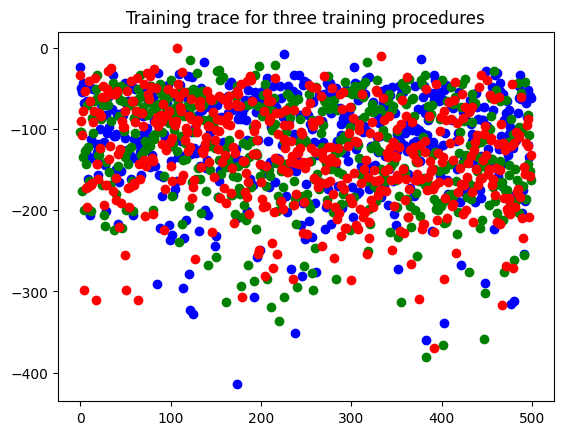

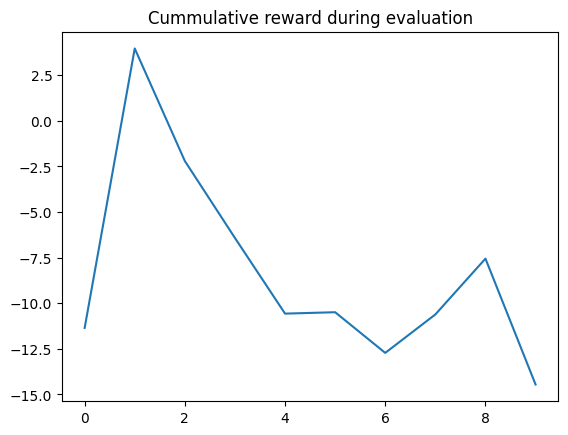

In [70]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] 

for i, x in enumerate(training_traces):
    values = [e.item() for e in x]
    plt.scatter(np.arange(0, len(values)), values, color=colors[i % len(colors)])
    
plt.title('Training trace for three training procedures')
plt.show()

test = np.mean(eval_traces, axis=0)
plt.plot(np.arange(0,len(test)), test)
plt.title('Cummulative reward during evaluation')
plt.show()

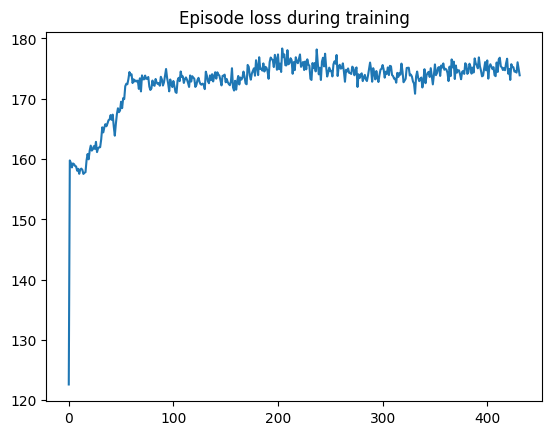

In [71]:
losses = [x.detach().item() for x in losses[0] if x != 0]
plt.plot(losses)
plt.title('Episode loss during training')
plt.show()

In [72]:
#Define DQN agent 
class factor_DQNagent(Agent):
    def __init__(self,  env:Env,
                ):
        """
        DQN agent with factorized Q-values 
        """
        self.env = env
        self.model = DQN(126, 8).to(DEVICE)

    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        self.model.load_state_dict(torch.load(savepath))

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        torch.save(self.model.state_dict(), savepath)

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,seed):
        # This should be called when the environment is reset
        self.env.reset(seed)

    def act(self, obs, info_=None):
        # takes an observation and returns an action
        action = {'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}
        
        with torch.no_grad():
          #We pick action with the larger expected reward.
          state = (torch.tensor([x.infected + x.dead for x in obs.city.values()], dtype=torch.float32, device=DEVICE).flatten().view(1,-1))**(1/4)
          output = self.model(state).view(4,2).argmax(dim=1).view(4, 1)

        for i, key in enumerate(action.keys()):
          action[key] = bool(output[i])

        return action

In [73]:
#Load environment 
env = Env(dyn) 

#Reset environement and set seed
obs, info = env.reset(seed=0)

agent = factor_DQNagent(env)
agent.load_model(ROOT_PATH +  '/best_DQN_4_2')
agent.reset(0)

#Run simulation and save outputed dict
log = []
i, max_step = 0, 30
while i < max_step:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info)
    i+=1

#Parse log
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

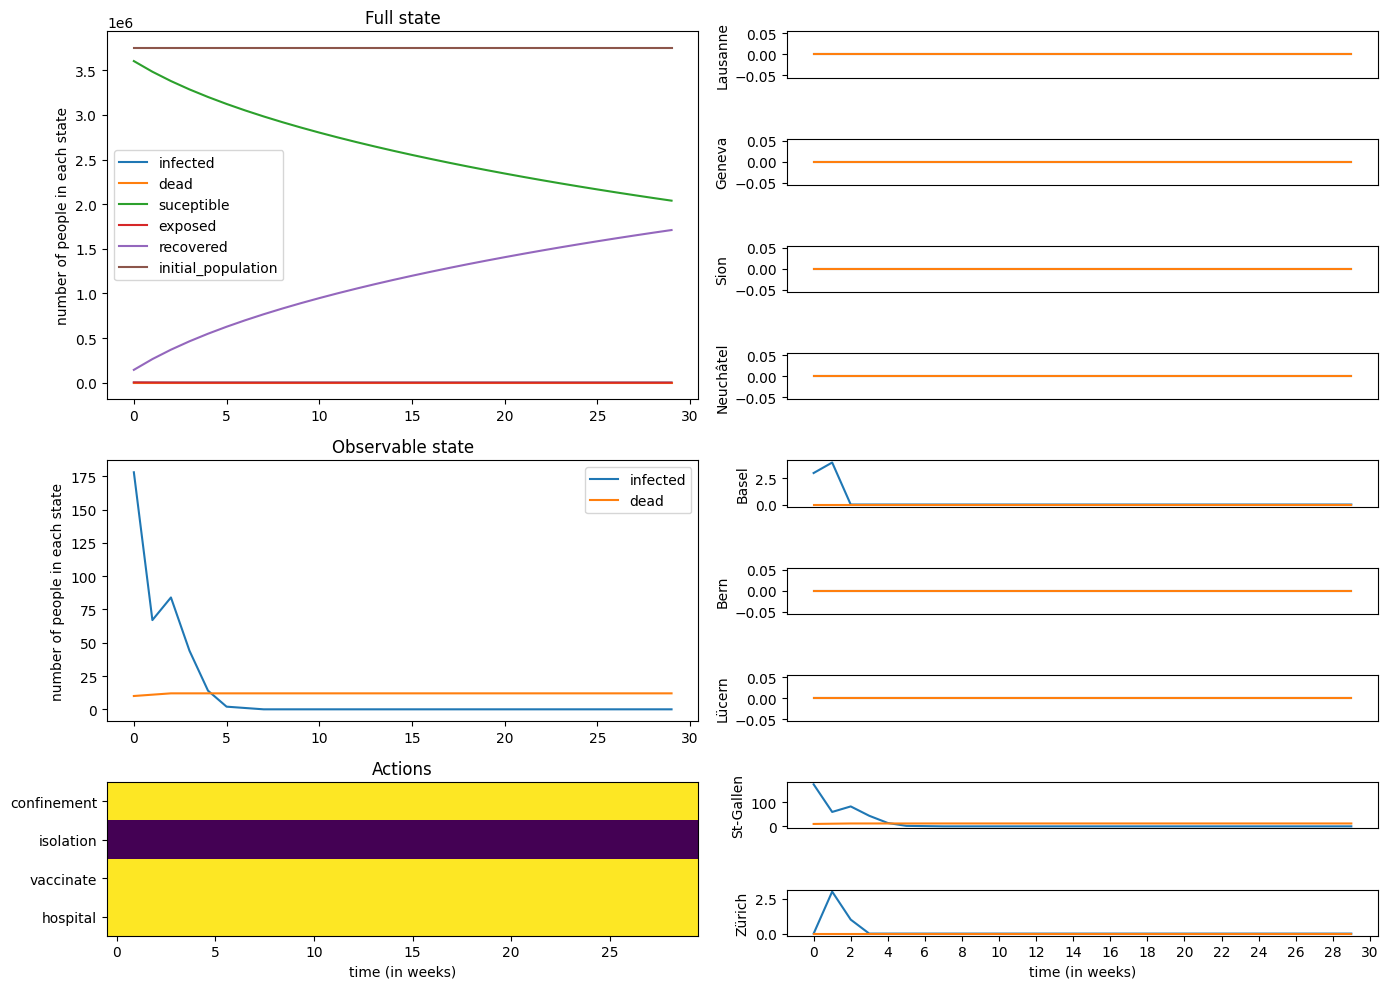

In [74]:
plot_episode(total, cities, actions)

In [ ]:
def evaluate_policy (policy, env, nb_episode:int, seed:List[int]):
  '''
  Run multiple episode using the inputed policy and compute for each episode:
  - the total number of confinement days/weeks
  - the cummulative reward
  - the total number of deaths
  parameters:
    policy: 
      policy used to chose next action
    env: 
      environment for the simulation
    nb_episode: int,
      number of episode played for the estimation
    seeds: int, 
      random sequence of seeds of length nb_episode for reproducibility
  '''

  #Run multiple episodes
  N_conf, cum_reward, nb_deaths = [], [], []
  for i in range(0,nb_episode):
    #Reset environement/agent and set seed
    obs, info = env.reset(seeds[i])
    policy.reset(seeds[i])
    
    finished = False
    ep_N_conf, ep_reward = 0, 0
    while not finished:
      action = policy.act(obs)
      obs, R, finished, info = env.step(action)

      #Log reward + confinement week
      ep_reward += R.item()
      ep_N_conf += int(action['confinement'] == True)

    N_conf.append(ep_N_conf); cum_reward.append(ep_reward)
    nb_deaths.append(obs.total.dead[-1])

  return N_conf, cum_reward, nb_deaths

In [ ]:
#Load environment 
env = Env(dyn) 

#Reset environement and set seed
obs, info = env.reset(seed=0)

#Define Russo agent 
agent = factor_DQNagent(env)
agent.load_model(ROOT_PATH +  '/best_DQN_4_2')
agent.reset(0)

seeds = np.arange(0,50,1)
N_conf, cum_reward, nb_deaths = evaluate_policy(agent, env, 50, seeds)

print(f'Average number of confinement weeks per episode: ', np.mean(N_conf))
print('Average cummulative reward: ', np.mean(cum_reward))
print('Average number of deaths: ', np.mean(nb_deaths))

Average number of confinement weeks per episode:  12.02
Average cummulative reward:  -1.6884584061801433
Average number of deaths:  22273.92


<Figure size 1800x800 with 3 Axes>

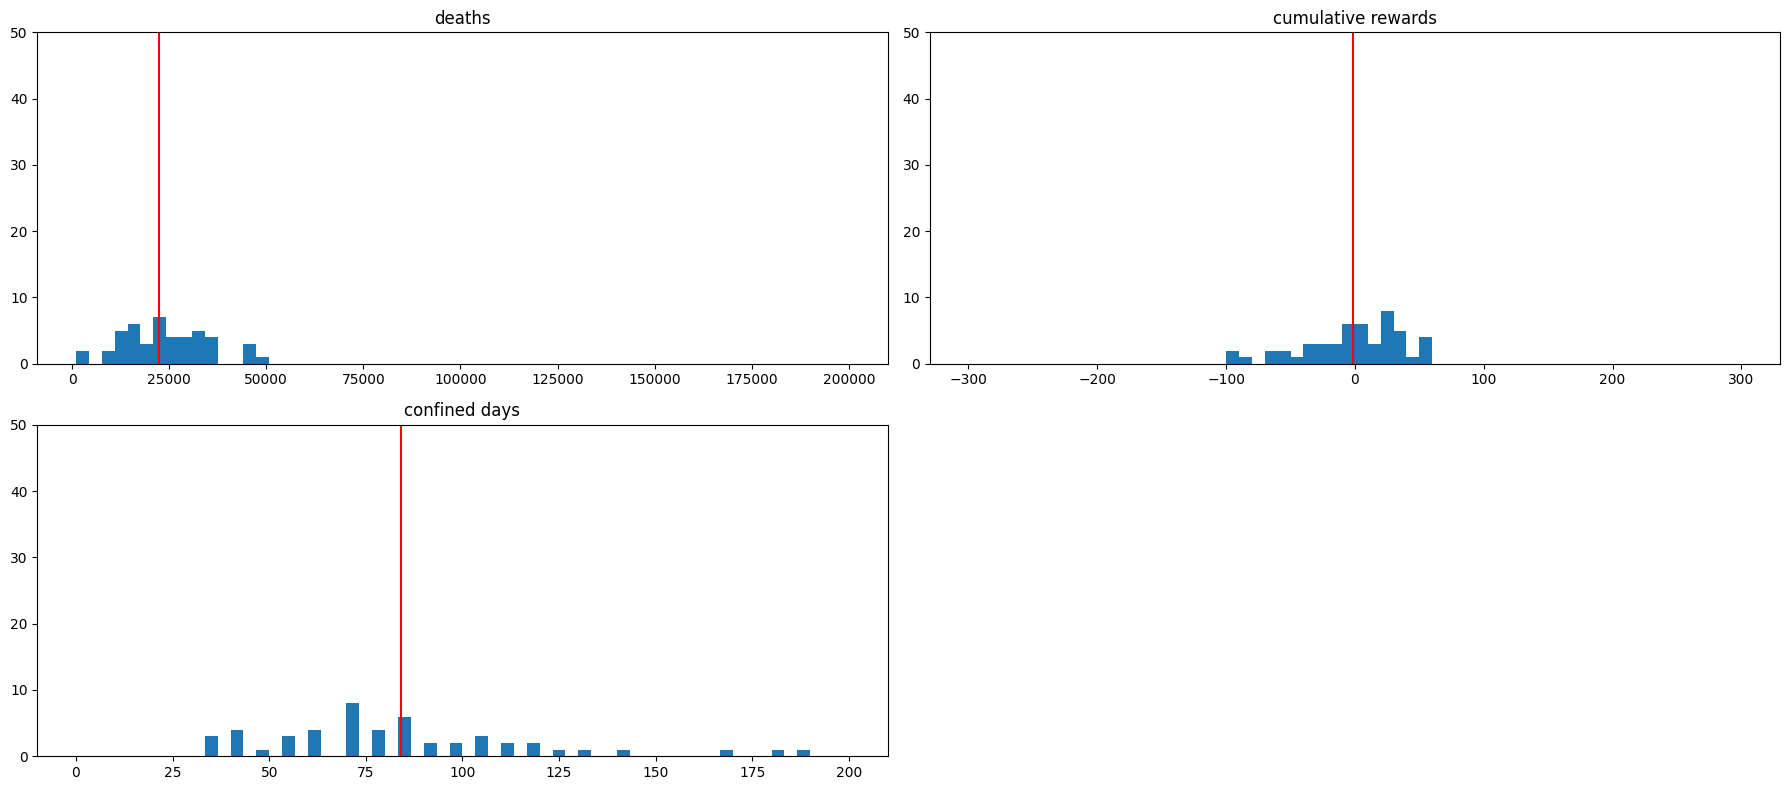

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(18,8))

hist_avg(ax[0,0], nb_deaths,'deaths')

hist_avg(ax[0,1], cum_reward,'cumulative rewards')

N_conf = [x*7 for x in N_conf] #Convert N_conf in days from week
hist_avg(ax[1,0], N_conf,'confined days')

fig.delaxes(ax[1,1])
fig.tight_layout()
plt.show()

# Question 5b

In [75]:
agents = {"Russo": RussoAgent, "SingleDQN" : binary_DQNagent, "ToggleDQN" : toogle_DQNagent, "FactorDQN" : factor_DQNagent}
model_paths = {"Russo": "", "SingleDQN" : "/best_DQN_3_2", "ToggleDQN" : "/best_DQN_4_1", "FactorDQN" : "/best_DQN_4_2"}

In [76]:
from typing import List

In [77]:
def evaluate_policy(agent, env, nb_episode:int, seed:List[int]):
    '''
    Run multiple episodes using the inputed agent and compute for each episode:
    - the total number of confinement days/weeks
    - the cumulative reward
    - the total number of deaths
    parameters:
      agent: 
        Agent used to chose next action. Must have a method 'act'.
      env: 
        Environment for the simulation.
      nb_episode: int,
        Number of episode played for the estimation.
      seeds: int, 
        Random sequence of seeds of length nb_episode for reproducibility.
    '''

    # Run multiple episodes
    N_conf, N_iso, N_vacc, N_hosp, cum_reward, nb_deaths, = [], [], [], [], [], []
    for i in range(0, nb_episode):
        # Reset environment and set seed
        obs, info = env.reset(seed[i])
        
        finished = False
        ep_N_conf, ep_N_iso, ep_N_vacc, ep_N_hosp, ep_reward = 0, 0, 0, 0, 0
        while not finished:
            # Action selection using the agent
            action = agent.act(obs, info)
            obs, R, finished, info = env.step(action)
            env.step(action=action)

            # Log reward + confinement week
            ep_reward += R.item()
            ep_N_conf += int(action['confinement'] == True)
            ep_N_iso += int(action['isolation'] == True)
            ep_N_vacc += int(action['vaccinate'] == True)
            ep_N_hosp += int(action['hospital'] == True)

        N_conf.append(ep_N_conf)
        N_iso.append(ep_N_iso)
        N_vacc.append(ep_N_vacc)
        N_hosp.append(ep_N_hosp)
        cum_reward.append(ep_reward)
        nb_deaths.append(obs.total.dead[-1])

    return N_conf,N_iso,N_vacc,N_hosp, cum_reward, nb_deaths

In [191]:
table_dict={}
for str_agent in agents.keys():
    #Load environment 
    env = Env(dyn) 

    #Reset environement and set seed
    obs, info = env.reset(seed=0)

    
    agent = agents[str_agent](env)
    agent.load_model(ROOT_PATH +  model_paths[str_agent])
    agent.reset(0)

    seeds = np.arange(0,50,1)
    N_conf,N_iso,N_vacc,N_hosp, cum_reward, nb_deaths = evaluate_policy(agent, env, 50, seeds)
    table_dict[str_agent] = {"Confinement" : np.mean(N_conf),
                             "Isolation" : np.mean(N_iso),
                             "Vaccinate" : np.mean(N_vacc),
                             "Hospital" : np.mean(N_hosp),
                             "Cumulative Reward" : np.mean(cum_reward),
                             "Deaths" : np.mean(nb_deaths)}
    

In [79]:
import pandas as pd
table_final = pd.DataFrame(table_dict)

In [80]:
table_final

,Russo,SingleDQN,ToggleDQN,FactorDQN
Confinement,7.840000,9.980000,9.16000,15.920000
Isolation,0.000000,0.000000,0.00000,0.000000
Vaccinate,0.000000,0.000000,0.00000,16.000000
Hospital,0.000000,0.000000,7.42000,13.100000
Cumulative Reward,-79.874335,-20.710353,-15.37656,-10.579246
Deaths,94244.760000,38876.260000,32933.68000,290.840000


# 5c

In [211]:
def simulate_with_q_values(agent, env, seed, episode_length):
    obs, info = env.reset(seed)
    episode_q_values = []

    for _ in range(episode_length):
        action = {'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}

        with torch.no_grad():
            state = (torch.tensor([x.infected + x.dead for x in obs.city.values()], dtype=torch.float32, device=DEVICE).flatten().view(1,-1))**(1/4)
            print(agent.model(state).view(4,2))
            q_values = agent.model(state).view(1,8)
            output = agent.model(state).view(4,2).argmax(dim=1).view(4, 1)

        for i, key in enumerate(action.keys()):
            action[key] = bool(output[i])

        episode_q_values.append(q_values)

        obs, reward, done, info = env.step(action)

        if done:
            break

    return episode_q_values

In [212]:
env = Env(dyn) 

#Reset environement and set seed
obs, info = env.reset(seed=0)

agent = factor_DQNagent(env)
agent.load_model(ROOT_PATH +  '/best_DQN_4_2')
agent.reset(0)

episode_q_values = simulate_with_q_values(agent, env, seed=0, episode_length=30)

tensor([[-0.2676, -0.1587],
        [ 0.2802,  0.0246],
        [-0.1211, -0.0938],
        [-0.3915, -0.0557]], device='cuda:0')
tensor([[-0.2360, -0.1542],
        [ 0.2847,  0.0406],
        [-0.1412, -0.1047],
        [-0.3887, -0.0474]], device='cuda:0')
tensor([[-0.2364, -0.1421],
        [ 0.2665,  0.0474],
        [-0.1580, -0.1130],
        [-0.3786, -0.0354]], device='cuda:0')
tensor([[-0.2500, -0.1488],
        [ 0.2646,  0.0415],
        [-0.1341, -0.0997],
        [-0.3894, -0.0352]], device='cuda:0')
tensor([[-0.2605, -0.1389],
        [ 0.2534,  0.0287],
        [-0.1090, -0.0926],
        [-0.3744, -0.0365]], device='cuda:0')
tensor([[-0.2498, -0.1133],
        [ 0.2651,  0.0558],
        [-0.1022, -0.0848],
        [-0.3684, -0.0152]], device='cuda:0')
tensor([[-0.2610, -0.1183],
        [ 0.2593,  0.0422],
        [-0.0870, -0.0776],
        [-0.3677, -0.0249]], device='cuda:0')
tensor([[-0.2609, -0.1071],
        [ 0.2523,  0.0389],
        [-0.0718, -0.0649],
      

In [213]:
la = [str(e) for key in actions.keys() for e in [ "no " + key[:4], key[:4]]]
la


['no conf', 'conf', 'no isol', 'isol', 'no vacc', 'vacc', 'no hosp', 'hosp']

[[-0.26762503 -0.15867183  0.28023946  0.02461815 -0.12114947 -0.09378097
  -0.3915149  -0.05572999]
 [-0.2360312  -0.1542354   0.28465834  0.04060461 -0.14117864 -0.10470271
  -0.38872117 -0.04744269]
 [-0.23643205 -0.14212677  0.2665194   0.04735937 -0.15798374 -0.11298132
  -0.37857944 -0.03542279]
 [-0.24999596 -0.14880657  0.2646141   0.04151975 -0.1340683  -0.09970281
  -0.38942122 -0.03521387]
 [-0.26048216 -0.13892916  0.2533891   0.0287037  -0.10902907 -0.09259449
  -0.37443477 -0.03648235]
 [-0.2497834  -0.11326781  0.2651298   0.05577351 -0.10222477 -0.0847777
  -0.36841622 -0.01516773]
 [-0.26102188 -0.11827281  0.259282    0.04221073 -0.08697288 -0.07761443
  -0.36771753 -0.02489653]
 [-0.2608503  -0.10710469  0.25230706  0.03885926 -0.07179222 -0.06486646
  -0.37012696 -0.0269222 ]
 [-0.2665984  -0.10624714  0.25643796  0.04091303 -0.06243325 -0.06053756
  -0.36635625 -0.02196695]
 [-0.26600626 -0.09954147  0.25870907  0.04597673 -0.0582835  -0.05342055
  -0.36867103 -0.0

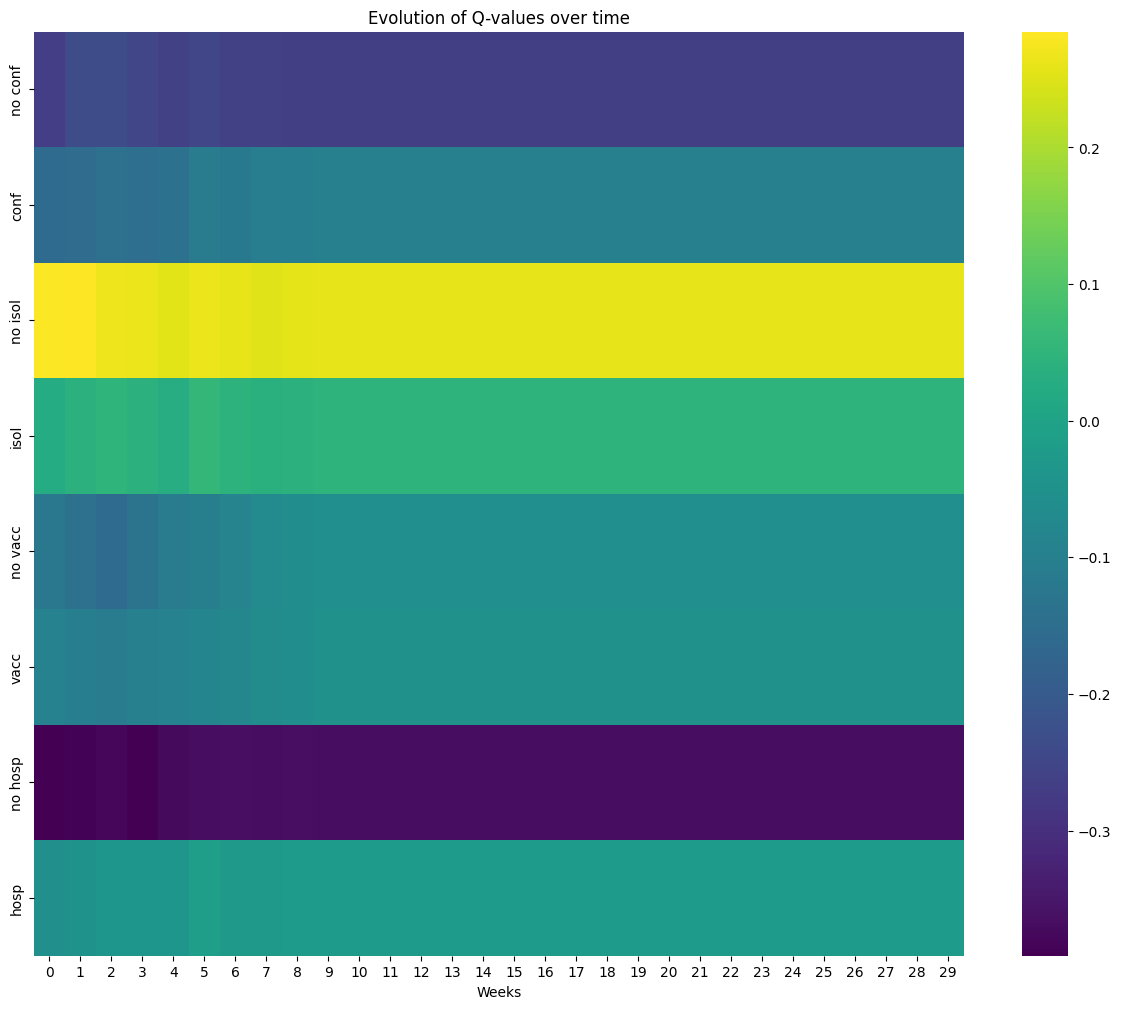

In [214]:

episode_q_values_matrix = torch.stack(episode_q_values).detach().cpu().numpy()
reshaped_q_values_matrix = episode_q_values_matrix.reshape(30,8)



plt.figure(figsize=(15, 12))
sns.heatmap(reshaped_q_values_matrix.T, cmap='viridis', yticklabels= la)
plt.xlabel("Weeks")
#plt.ylabel("Action Selections")
plt.title("Evolution of Q-values over time")
plt.show()

print( reshaped_q_values_matrix)

In [215]:
def simulate_with_q_values_single_action(agent, env, seed, episode_length):
    obs, info = env.reset(seed)
    episode_q_values = []

    for _ in range(episode_length):
        action = {'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}

        with torch.no_grad():
            state = (torch.tensor([x.infected + x.dead for x in obs.city.values()], dtype=torch.float32, device=DEVICE).flatten().view(1,-1))**(1/4)
            q_values = agent.model(state).view(1,2)
            output = q_values.argmax(dim=1).view(1, 1)
    
        action['confinement'] = bool(output[0])
        print(action)
        episode_q_values.append(q_values)

        obs, reward, done, _ = env.step(action)

        if done:
            break

    return episode_q_values

In [216]:
env = Env(dyn) 

#Reset environement and set seed
obs, info = env.reset(seed=0)

agent = binary_DQNagent(env)
agent.load_model(ROOT_PATH +  '/best_DQN_3_2')
agent.reset(0)

episode_q_values = simulate_with_q_values_single_action(agent, env, seed=0, episode_length=30)

{'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': True, 'i

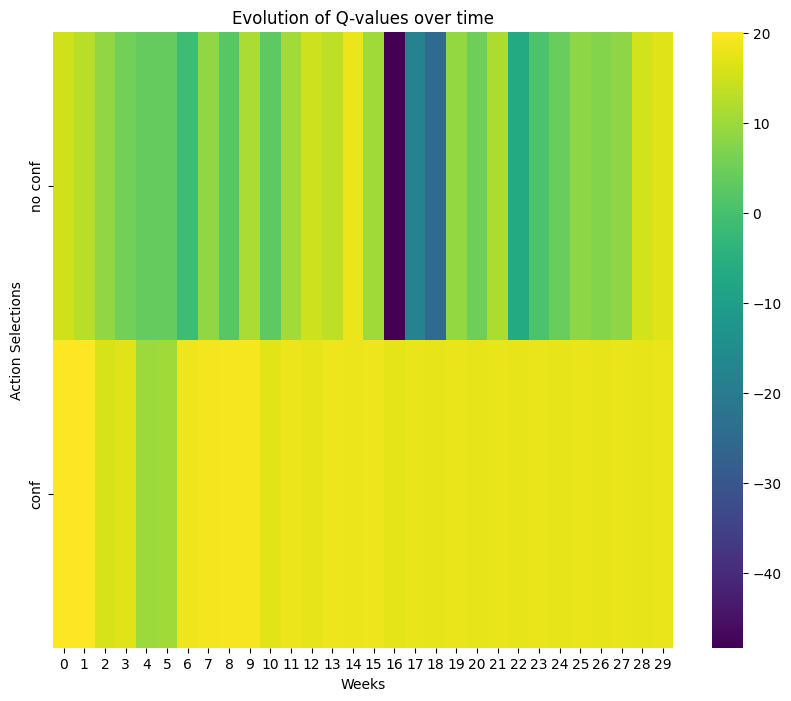

In [217]:

episode_q_values_matrix = torch.stack(episode_q_values).detach().cpu().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(episode_q_values_matrix.reshape(2,30), cmap='viridis',yticklabels=["no conf","conf"])
plt.xlabel("Weeks")
plt.ylabel("Action Selections")
plt.title("Evolution of Q-values over time")
plt.show()